# 장애인콜택시 대기시간 예측
## 단계3. 모델링

## 0.미션

* 1.시계열 데이터에 맞는 전처리
    * 데이터가 2015 ~ 2022년까지 데이터 입니다.
    * 이 중 2022년 10월 ~ 2022년 12월까지(3개월)의 데이터는 성능 검증용으로 사용합니다.
    * 나머지 데이터를 이용하여 학습 및 튜닝을 수행합니다.
    * 이를 위한 데이터 전처리를 수행하시오.
* 2.모델 최적화
    * 머신러닝 
        * 알고리즘 중 3가지 이상을 선정하여 모델링을 수행합니다.
        * 각각 알고리즘에 맞는 튜닝 방법으로 최적의 모델을 만듭니다.
    * 딥러닝
        * 모델 구조를 2가지 이상을 생성하고 모델링을 수행합니다.
        * epochs, learning_rate 등을 조절하며 성능을 튜닝합니다.
    * 성능 평가
        * 시계열 그래프로 모델의 실제값과 예측값을 시각화하여 비교합니다.
        * 성능 지표 (MAE, MAPE) 를 사용해 가장 성능이 높은 모델을 선정합니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

### (2) 데이터 로딩
* 주어진 데이터셋
    * [2.탐색적 데이터분석] 단계에서 저장한 파일 : data2.pkl
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
    * 2) 구글콜랩

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [ ]:
# path = ''

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.19_미니프로젝트 6차_3_4일차_실습자료/'

#### 3) 데이터 읽어오기

In [4]:
file1 = 'data2.pkl'

In [20]:
data = joblib.load(path + file1)
data = data.reset_index(drop=True)

## 2.데이터 준비
* **세부요구사항**
    * NaN에 대한 조치를 수행하시오.
        * rolling 혹은 shift로 발생된 초기 행의 NaN은 삭제해도 무방합니다.
    * 가변수화 : 범주형에 대해서 가변수화를 수행합니다.
    * 데이터분할
        * 시계열 데이터 특성에 맞게 분할합니다.
        * 마지막 91일(3개월) 데이터를 검증셋으로 사용합니다.

### (1) NA 조치

In [21]:
# 미리 제거했음
data.isnull().sum()

Date                0
Submissions         0
Boardings           0
Avg_wait            0
target              0
humidity_min(%)     0
Weekday             0
Month               0
Season              0
Weekend             0
Holidays            0
Wait_MA7            0
Boarding_percent    0
dtype: int64

### (2) 가변수화

In [22]:
cat_cols = data.select_dtypes('object').columns
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
data.head(2)

<ipython-input-22-edc443ef0d81>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
<ipython-input-22-edc443ef0d81>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
<ipython-input-22-edc443ef0d81>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
<ipython-input-22-edc443ef0d81>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = pd.get_dummies(data, columns=cat_cols, drop_first=True)


,Date,Submissions,Boardings,Avg_wait,target,humidity_min(%),Wait_MA7,Boarding_percent,Weekday_1,Weekday_2,...,Month_8,Month_9,Month_10,Month_11,Month_12,Season_spring,Season_summer,Season_winter,Weekend_1,Holidays_1
0,2015-01-07,4085,3676,24.7,21.2,27.0,23.657143,0.899878,0,1,...,0,0,0,0,0,0,0,1,0,0
1,2015-01-08,4030,3728,21.2,21.8,38.0,23.371429,0.925062,0,0,...,0,0,0,0,0,0,0,1,0,0


### (3) 데이터분할
* **세부요구사항**
    * 마지막 91일 간의 데이터를 검증 셋으로 만듭니다. (2022-10-01 ~ )
    * 이 기간의 날짜 리스트를 별도로 저장하여, 모델 검증시 시각화할 때 활용합니다.

In [50]:
idx = data[data['Date'] == '2022-10-01'].index[0]

train_data = data.loc[:idx]

test_data = data.loc[idx :]
test_date = test_data['Date']

#### 1) x, y 나누기

In [51]:
# 'Date' column 제거
train_data.drop('Date', axis=1, inplace=True)
test_data.drop('Date', axis=1, inplace=True)

x_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

x_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

<ipython-input-51-0dd047cdb196>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop('Date', axis=1, inplace=True)
<ipython-input-51-0dd047cdb196>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop('Date', axis=1, inplace=True)


#### 2) train : validation 나누기
* 힌트 : train_test_split(  ,   ,  test_size = 91, shuffle = False) 

In [52]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=False, test_size=91)

### (4) Scaling
* KNN, SVM 알고리즘 및 DL을 적용하기 위해서는 스케일링을 해야 합니다.

In [53]:
mm_scaler = MinMaxScaler()

x_train = mm_scaler.fit_transform(x_train)
x_val = mm_scaler.transform(x_val)
x_test = mm_scaler.transform(x_test)

## 3.모델링
* **세부요구사항**
    * 머신러닝 알고리즘 중 3가지 이상을 사용하여 모델을 만들고 튜닝을 수행합니다.
    * 딥러닝 모델 구조 2가지 이상을 설계하고 모델을 생성합니다.
    * 성능 측정은 MAE, MAPE로 수행합니다.
    * 모델링 후 실제값과 예측값을 시각화(라인차트)하여 분석합니다.

### (1) 머신러닝

#### 1) 모델1

In [55]:
from sklearn.linear_model import LinearRegression

In [88]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [89]:
y_pred = lr_model.predict(x_val)
print("================Validation=================")
print(f"MAE : {mean_absolute_error(y_val, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_val, y_pred)}")

y_pred = lr_model.predict(x_test)
print("===================Test===================")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred)}")

================Validation=================
MAE : 4.343948217046564
MAPE : 0.11945095281751489
===================Test===================
MAE : 4.418472588735316
MAPE : 0.11189013778917423


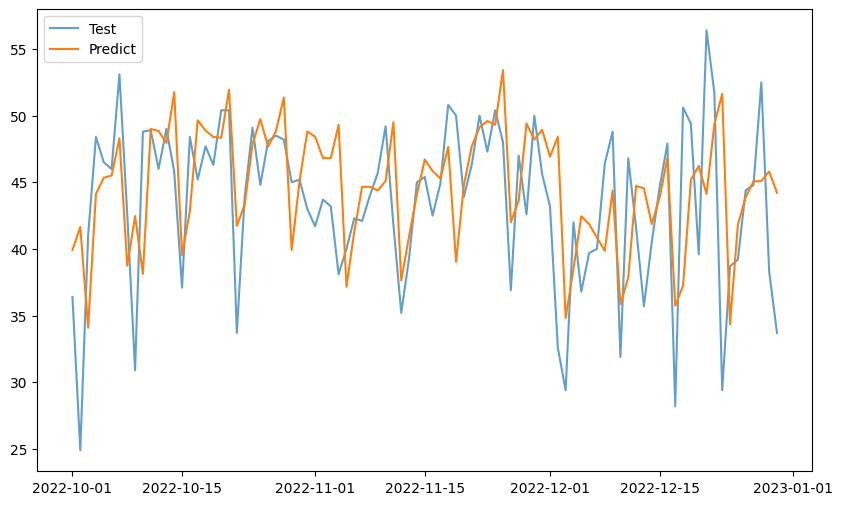

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(test_date, y_test, label='Test', alpha=0.7)
plt.plot(test_date, y_pred, label='Predict', alpha=1)
plt.legend()
plt.show()

#### 2) 모델2

In [61]:
from lightgbm import LGBMRegressor

In [91]:
lgbm_model = LGBMRegressor()
lgbm_model.fit(x_train, y_train)

LGBMRegressor()

In [92]:
y_pred = lgbm_model.predict(x_val)
print("================Validation=================")
print(f"MAE : {mean_absolute_error(y_val, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_val, y_pred)}")

y_pred = lgbm_model.predict(x_test)
print("===================Test===================")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred)}")

================Validation=================
MAE : 4.9604976919238
MAPE : 0.13726257559837135
===================Test===================
MAE : 4.7155336986207
MAPE : 0.1194058535532677


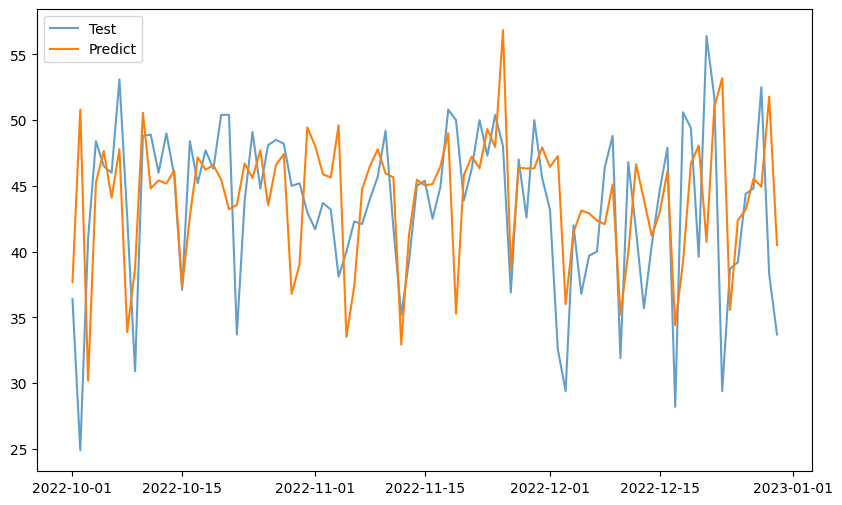

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(test_date, y_test, label='Test', alpha=0.7)
plt.plot(test_date, y_pred, label='Predict', alpha=1)
plt.legend()
plt.show()

#### 3) 모델3

In [94]:
from sklearn.svm import SVR

svm_model = SVR()
svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_val)
print("================Validation=================")
print(f"MAE : {mean_absolute_error(y_val, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_val, y_pred)}")

y_pred = svm_model.predict(x_test)
print("===================Test===================")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred)}")

================Validation=================
MAE : 4.0526560966989225
MAPE : 0.11129445923466023
===================Test===================
MAE : 4.398410481593983
MAPE : 0.11083999772658322


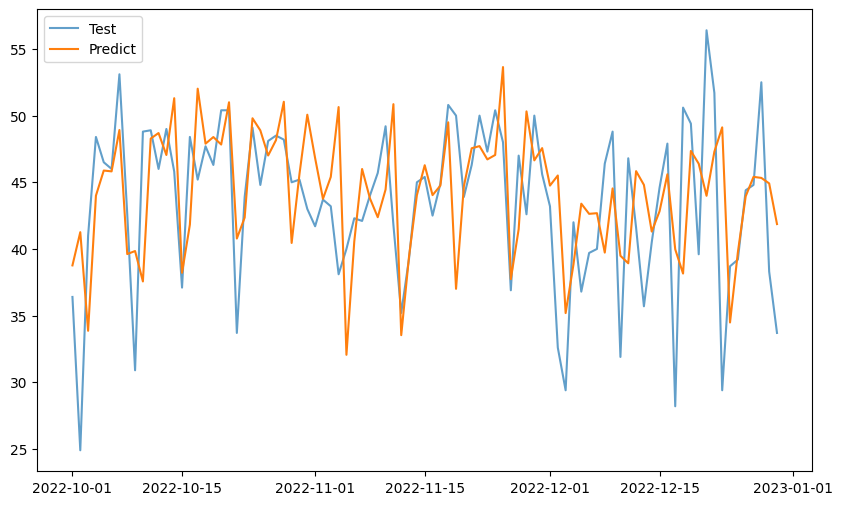

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(test_date, y_test, label='Test', alpha=0.7)
plt.plot(test_date, y_pred, label='Predict', alpha=1)
plt.legend()
plt.show()

### (2) 딥러닝

In [96]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

#### 1) 모델1

In [97]:
# 세션 초기화
K.clear_session()

# 모델 쌓기
il = Input(shape=(28, ))
hl = Dense(512, activation='relu')(il)
hl = BatchNormalization()(hl)
hl = Dense(256, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dense(128, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.2)(hl)
hl = Dense(64, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.2)(hl)
ol = Dense(1)(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='mae', metrics=['mape'], optimizer='adam')

# summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 512)               14848     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               32896 

In [98]:
es = EarlyStopping(patience=5, verbose=1)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                    epochs=100, callbacks=[es])

Epoch 1/100
86/86 [==============================] - 4s 13ms/step - loss: 39.7817 - mape: 98.6456 - val_loss: 38.0040 - val_mape: 96.7977
Epoch 2/100
86/86 [==============================] - 1s 6ms/step - loss: 38.1234 - mape: 93.9539 - val_loss: 36.1777 - val_mape: 91.8930
Epoch 3/100
86/86 [==============================] - 1s 7ms/step - loss: 34.5899 - mape: 84.1415 - val_loss: 31.3379 - val_mape: 79.1407
Epoch 4/100
86/86 [==============================] - 1s 7ms/step - loss: 28.6213 - mape: 67.4991 - val_loss: 24.0759 - val_mape: 59.9687
Epoch 5/100
86/86 [==============================] - 1s 6ms/step - loss: 20.2621 - mape: 45.5205 - val_loss: 11.2348 - val_mape: 27.3253
Epoch 6/100
86/86 [==============================] - 1s 6ms/step - loss: 11.8699 - mape: 27.3368 - val_loss: 5.1714 - val_mape: 13.7159
Epoch 7/100
86/86 [==============================] - 1s 6ms/step - loss: 7.8175 - mape: 19.3601 - val_loss: 9.0596 - val_mape: 23.6115
Epoch 8/100
86/86 [========================

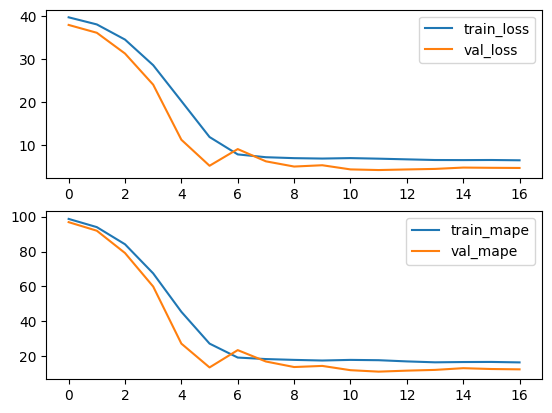

In [99]:
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mape'], label='train_mape')
plt.plot(history.history['val_mape'], label='val_mape')
plt.legend()
plt.show()

In [100]:
y_pred = model.predict(x_test)

3/3 [==============================] - 0s 4ms/step


In [103]:
print("===================Test===================")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred)}")

===================Test===================
MAE : 5.119998089297788
MAPE : 0.12268493404830483


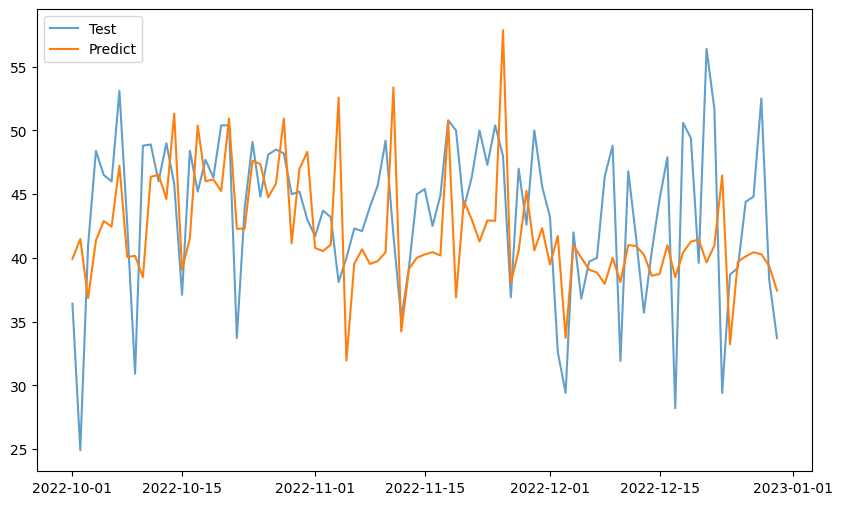

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(test_date, y_test, label='Test', alpha=0.7)
plt.plot(test_date, y_pred, label='Predict', alpha=1)
plt.legend()
plt.show()

#### 2) 모델2

In [112]:
# 세션 초기화
K.clear_session()

# 모델 쌓기
il = Input(shape=(28, ))
hl = Dense(128, activation='relu')(il)
hl = Dense(128, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dense(64, activation='relu')(hl)
hl = Dense(64, activation='relu')(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.2)(hl)
ol = Dense(1)(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='mae', metrics=['mape'], optimizer='adam')

# summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 128)               3712      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                             

In [113]:
es = EarlyStopping(patience=5, verbose=1)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                    epochs=100, callbacks=[es])

Epoch 1/100
86/86 [==============================] - 2s 5ms/step - loss: 39.7671 - mape: 98.2008 - val_loss: 38.5978 - val_mape: 98.4002
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 38.0548 - mape: 93.6116 - val_loss: 36.6422 - val_mape: 93.2047
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 34.4869 - mape: 83.8151 - val_loss: 32.5069 - val_mape: 82.3313
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 28.4771 - mape: 67.3875 - val_loss: 24.7243 - val_mape: 61.9566
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 20.1404 - mape: 45.3698 - val_loss: 10.8417 - val_mape: 26.0777
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 11.6712 - mape: 26.9742 - val_loss: 6.9041 - val_mape: 18.2377
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 7.7167 - mape: 18.9638 - val_loss: 6.4625 - val_mape: 18.0017
Epoch 8/100
86/86 [=========================

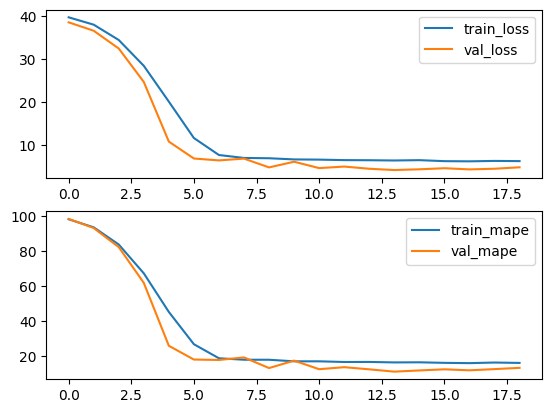

In [114]:
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mape'], label='train_mape')
plt.plot(history.history['val_mape'], label='val_mape')
plt.legend()
plt.show()

3/3 [==============================] - 0s 4ms/step
===================Test===================
MAE : 4.6568591861934445
MAPE : 0.11538736337276884


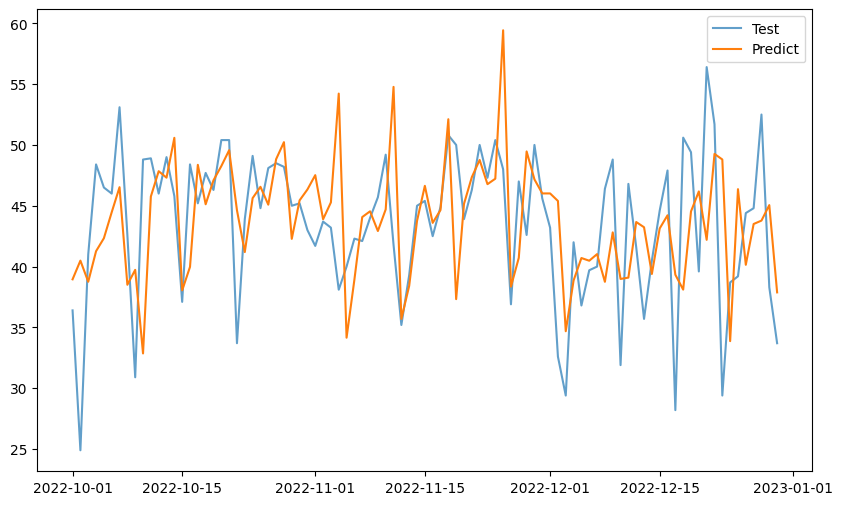

In [115]:
y_pred = model.predict(x_test)
print("===================Test===================")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred)}")

plt.figure(figsize=(10, 6))
plt.plot(test_date, y_test, label='Test', alpha=0.7)
plt.plot(test_date, y_pred, label='Predict', alpha=1)
plt.legend()
plt.show()

#### 3) 모델3

In [116]:
# 세션 초기화
K.clear_session()

# 모델 쌓기
il = Input(shape=(28, ))
hl = Dense(128, activation='relu')(il)
hl = Dense(64, activation='relu')(hl)
ol = Dense(1)(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='mae', metrics=['mape'], optimizer='adam')

# summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 128)               3712      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________________________


In [117]:
es = EarlyStopping(patience=5, verbose=1)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                    epochs=100, callbacks=[es])

Epoch 1/100
86/86 [==============================] - 1s 4ms/step - loss: 26.8424 - mape: 65.6512 - val_loss: 6.7801 - val_mape: 19.2246
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 9.0685 - mape: 23.3902 - val_loss: 4.6102 - val_mape: 13.0067
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 7.2854 - mape: 18.5656 - val_loss: 4.7818 - val_mape: 13.5725
Epoch 4/100
86/86 [==============================] - 0s 2ms/step - loss: 6.1134 - mape: 15.7314 - val_loss: 4.4045 - val_mape: 12.2114
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 5.7463 - mape: 14.8900 - val_loss: 5.1444 - val_mape: 14.3941
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 5.6429 - mape: 14.5782 - val_loss: 4.2787 - val_mape: 11.6746
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 5.5807 - mape: 14.3530 - val_loss: 4.2602 - val_mape: 11.4684
Epoch 8/100
86/86 [==============================] - 0

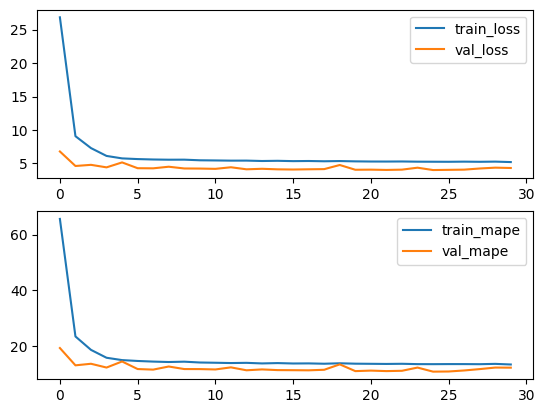

In [118]:
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mape'], label='train_mape')
plt.plot(history.history['val_mape'], label='val_mape')
plt.legend()
plt.show()

3/3 [==============================] - 0s 3ms/step
===================Test===================
MAE : 4.617992074148995
MAPE : 0.11612565406671532


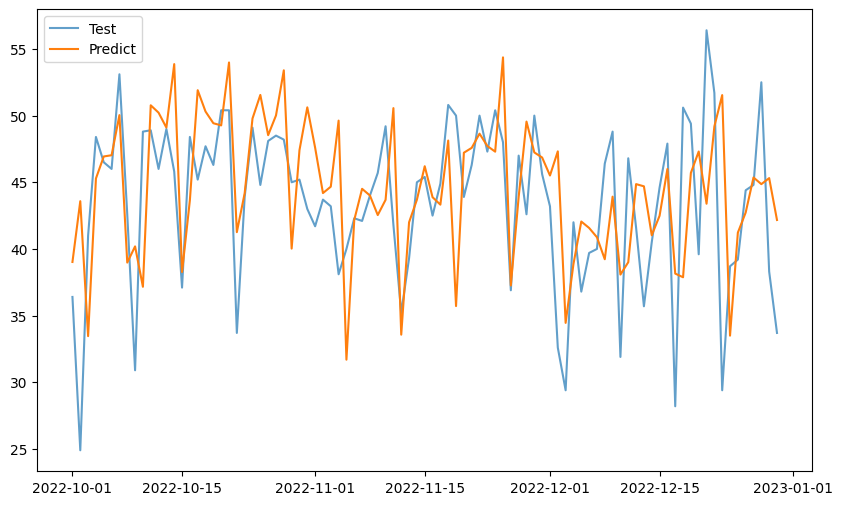

In [119]:
y_pred = model.predict(x_test)
print("===================Test===================")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MAPE : {mean_absolute_percentage_error(y_test, y_pred)}")

plt.figure(figsize=(10, 6))
plt.plot(test_date, y_test, label='Test', alpha=0.7)
plt.plot(test_date, y_pred, label='Predict', alpha=1)
plt.legend()
plt.show()

## 4.모델 비교
* **세부요구사항**
    * 모델링 단계에서 생성한 모든 모델의 성능을 하나로 모아서 비교합니다.
    * 가장 성능이 높은 모델을 선정합니다.